# Problem Set 3 (24 points)

Use the same `sentencing_cleaned` data from Problem Set 2 for this assignment. 

In Problem Set 2, you investigated one form of disparity in the US criminal justice system: probation versus incarceration.

Here, you'll investigate a second type of disparity---the length of a defendant's sentence---and also investigate the disparities faced by defendants sentenced by the same judge for the same crime. 

As a reminder, the codebook is available at this link:  https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf)

# 0. Load packages and imports

In [85]:
## basic functionality
import pandas as pd
import numpy as np
import re
import os
import plotnine
from plotnine import *

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## 1.1 Filter to defendants who were incarcerated and construct a sentence length variable (10 points)

**Part A:**

- Filter to sentences that involve incarceration (same Illinois Department of Corrections logic as in problem set two: 
incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections")
- Filter out non-numeric sentence lengths (e.g., Term, Pounds, or Dollars)
- Filter to Black or White defendants

**Concepts tested and resources**: this question tests filtering rows based on logical conditions. Here are some resources:
- DataCamp on .loc: https://campus.datacamp.com/courses/data-manipulation-with-pandas/slicing-and-indexing-dataframes?ex=3
- Row subsetting section in this activity: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/01_pandas_datacleaning_solutions.ipynb


### Part A

In [86]:
## your code here that reads in data and filters the rows

# Import the dataset
df = pd.read_csv("pset2_inputdata/sentencing_cleaned.csv")

#Filter to sentences that involve incarceration
df_inc= df[df.COMMITMENT_TYPE=="Illinois Department of Corrections"]

#Filter out non-numeric sentence lengths (e.g., Term, Pounds, or Dollars)
df_inc = df_inc[df_inc.COMMITMENT_UNIT.isin(["Dollars", "Pounds", "Term"]) == False]

#Filter to Black or White defendants
df_bw = df_inc[df_inc.is_black_derived|df_inc.is_white_derived].copy()

/var/folders/xl/m01l3f9d4wj5kbhrzm8dvp480000gn/T/ipykernel_49586/2905173249.py:4: DtypeWarning: Columns (10,11,16,25) have mixed types. Specify dtype option on import or set low_memory=False.


### Part B


**Part B**: Then, follow the instructions in the codebook (combining `COMMITMENT_TERM` with `COMMITMENT_UNIT`) to create a standard sentence length in days column (`senlength_derived`) that measures the sentence in days. To simplify, you can assume that:

- 1 hour = 1/24th of a day
- 1 year = 365 days
- 1 month = 30.5 days
- 1 week = 7 days
- Natural life = difference between the age of 100 and the defendant's age at incident (cleaned; if missing, code to age 20); note that this is a simplification since age at incident != age at sentencing 

Print the following cols for an example of each type (eg an example of originally hours; an example of natural life): `COMMITMENT_TERM`, `COMMITMENT_UNIT`, `age_derived` and your new standardized sentence length column

Print the summary of that column (`senlength_derived`) using the .describe() command

**Concepts tested and resources**: there are many approaches but a couple ways are:
- np.select covered in the slides and this activity notebook: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/01_pandas_datacleaning_solutions.ipynb
- writing a function that takes in one row as an argument and has a series of if, elif, else conditions where different commitment_units are translated into days. To execute this function, you can use the .apply function but apply it with axis = 1 (row-wise). Resources for that include: (1) the activity notebook on user-defined functions (https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/02_functions_part1_solutions.ipynb); (2) the activity notebook covering apply (same as above)

**Hint on output**: see GitHub issue for the summary stats we get from running .describe()

In [87]:
## Your code here on translation of units
import random

#List of Conditions
df_bw["COMMITMENT_TERM"] = df_bw["COMMITMENT_TERM"].astype("float")


condlist = [df_bw.COMMITMENT_UNIT=="Hours", 
            df_bw.COMMITMENT_UNIT=="Year(s)", 
            df_bw.COMMITMENT_UNIT=="Months", 
            df_bw.COMMITMENT_UNIT=="Weeks",
            df_bw.COMMITMENT_UNIT=="Natural Life"]

# List of Choices

choicelist = [df_bw.COMMITMENT_TERM * (1/24),
              df_bw.COMMITMENT_TERM * 365,
              df_bw.COMMITMENT_TERM * 30.5,
              df_bw.COMMITMENT_TERM * 7,
             100 - df_bw.age_derived]
              
# Creating a standard sentence length in days column
df_bw["senlength_derived"] = np.select(condlist, choicelist)

In [88]:
## Your code here on printing example of each type of committment unit and what it's senlength_derived is

# Print the four columns "COMMITMENT_TERM", "COMMITEMENT_UNIT", "age_derived", "selength_derived" 
# for when COMMITMENT UNIT is either "Hours", "Year(s)", "Months", "Weeks", "Natural Life"
# I used random.choice so that it would choose any row that satisfies the condition

example_df_bw = df_bw[["COMMITMENT_UNIT", "COMMITMENT_TERM","age_derived","senlength_derived"]]
example_df_bw=[example_df_bw.loc[random.choice(df_bw[df_bw.COMMITMENT_UNIT== ex].index.values.astype("int"))] for ex in ["Hours", "Year(s)", "Months", "Weeks", "Natural Life"]]

pd.DataFrame(example_df_bw)


,COMMITMENT_UNIT,COMMITMENT_TERM,age_derived,senlength_derived
92475,Hours,1.0,22.0,0.041667
93684,Year(s),1.0,47.0,365.000000
2363,Months,18.0,50.0,549.000000
15310,Weeks,2.0,23.0,14.000000
980,Natural Life,1.0,42.0,58.000000


In [5]:
## Your code here with the .describe() command summary of the senlength_derived column
df_bw.senlength_derived.describe()

count     58289.000000
mean       1372.330221
std        1930.066434
min           0.000000
25%         365.000000
50%         915.000000
75%        1460.000000
max      147825.000000
Name: senlength_derived, dtype: float64

## 1.2 Examine disparities in length within the same judge and offense category: constructing matched pairs (14 points)



### Part A 

Keep the above ~58k row dataset subsetting only to sentences involving incarceration. Then, further subset the rows to:
- Those sentenced `judgeid_derived` = `judge_21` 
- `simplified_offense_derived` == "Narcotics"

Use `shape` to print the dimensions of the resulting dataframe

**Concepts and resources**: row subsetting using logical conditions; see above resources
 

In [89]:
## your code here to filter rows and check the shape


#subseting to rows that "judgeid_derived == judge 21" and "`simplified_offense_derived` == "Narcotics""
df_bw_sp = df_bw[df_bw.judgeid_derived == "judge_21"]
df_bw_sp = df_bw_sp[df_bw_sp.simplified_offense_derived == "Narcotics"]

df_bw_sp.shape

(53, 53)

### Part B

For each defendant sentenced by judge_21, you want to construct "matched groups" of defendants who:

- Are the same exact age and
- Are the same gender but 
- Differ in race from the focal defendant

Write a user-defined function to find any/all matched defendants for each focal defendant of judge 21. You can structure the function in various ways but one way is to write a function similar to the class example where we find similar crimes to a focal crime for one focal crime; in this case, we want to:

- Iterate over unique defendants sentenced by judge 21 (use `CASE_PARTICIPANT_ID` to identify each unique defendant)
- Find other defendants in the judge 21 pool who (1) have a different race from that focal defendant but (2) the same gender and age 


**Concepts and resources**: 

- Slides and activity code on user-defined functions and iterating using list comprehension: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/02_functions_part1_solutions.ipynb 
- You can either write code in the function to add columns with the attributes of the focal defendant (existing material) or using `pd.merge` to join these on after; we'll be covering `pd.merge` on Wednesday 09.21 but here are some slides (slide 17-20) from my previous course in meantime: https://github.com/rebeccajohnson88/qss20_slides_activities/blob/main/slides/s21_slides/qss20_s21_class4.pdf 


**Hints on output**: 

- Some focal defendants may not have any matches; they can be excluded from the results 
- In the way we wrote our function, each iteration of the function returns a single dataframe with the focal defendant's matched defendants


In [7]:
## your code here to define function

def find_match(ID, df):
    #subsetting the dataframe so that it will only have the columns that we need 
    df=df[["CASE_PARTICIPANT_ID", "is_black_derived", "age_derived", "GENDER", "senlength_derived"]].reset_index()
    
    #extracting the focal case in a single dataframe
    focal = df[df.CASE_PARTICIPANT_ID == ID]
    
    #list comprehending dataframe so that match_age will only have those that have the same age with focal
    match_age = pd.DataFrame([df.iloc[match_index] for match_index in df.index if (df.age_derived[match_index] == focal.age_derived.values)]).reset_index()
    
    #if there is more than one case that fit the age criterion, it continues to the second comparison
    if len(match_age) != 0 : 
        
        #cleaning the columns to ease the next list comprehension process
        match_age = match_age[["index", "CASE_PARTICIPANT_ID", "is_black_derived", "age_derived", "GENDER", "senlength_derived"]]

        #list comprehending dataframe so that match_age will only have those that have the same gender with focal
        match_gender = pd.DataFrame([match_age.iloc[match_index] for match_index in match_age.index if (match_age.GENDER[match_index] == focal.GENDER.values)]).reset_index()
        
        #if there is more than one case that fit the gender criterion, it continues to the second comparison
        if len(match_gender) !=0 :
            match_gender = match_gender[["index", "CASE_PARTICIPANT_ID", "is_black_derived", "age_derived", "GENDER", "senlength_derived"]]

            match_race = pd.DataFrame([match_gender.iloc[match_index] for match_index in match_gender.index if (match_gender.is_black_derived[match_index] != focal.is_black_derived.values)]).reset_index()

            if len(match_race) != 0:
                result = {
                    'CASE_PARTICIPANT_ID_focal': [ID for a in range(len(match_race.CASE_PARTICIPANT_ID))],
                    'CASE_PARTICIPANT_ID_match': match_race.CASE_PARTICIPANT_ID,
                    'is_black_derived_focal': [focal.is_black_derived.values[0] for a in range(len(match_race.CASE_PARTICIPANT_ID))],
                    'senlength_derived_focal': [focal.senlength_derived.values[0] for a in range(len(match_race.CASE_PARTICIPANT_ID))],
                    'senlength_derived_match': match_race.senlength_derived
                } 
                return pd.DataFrame(result)
            else: return
        else: return
    else: return



In [8]:
## your code here to execute the function 

find_match(808109112733, df_bw_sp)

,CASE_PARTICIPANT_ID_focal,CASE_PARTICIPANT_ID_match,is_black_derived_focal,senlength_derived_focal,senlength_derived_match
0,808109112733,768307912970,True,2190.0,730.0
1,808109112733,769939231128,True,2190.0,730.0
2,808109112733,774967571640,True,2190.0,365.0


**Part B**: using the results from Part A, use `pd.concat` or another approach to create a dataframe that compares the (1) race and sentence length for the focal defendant to (2) the sentence length for other defendants. Using this dataframe, show this comparison for focal defendant: `CASE_PARTICIPANT_ID` == `808109112733`


In [9]:
## your code to rowbind all matches and to highlight the comparison

df_bw_compare = pd.concat([find_match(check, df_bw_sp) for check in df_bw_sp.CASE_PARTICIPANT_ID], ignore_index = True)

## for the example defendant 
df_bw_compare[df_bw_compare.CASE_PARTICIPANT_ID_focal == 808109112733]

,CASE_PARTICIPANT_ID_focal,CASE_PARTICIPANT_ID_match,is_black_derived_focal,senlength_derived_focal,senlength_derived_match
56,808109112733,768307912970,True,2190.0,730.0
57,808109112733,769939231128,True,2190.0,730.0
58,808109112733,774967571640,True,2190.0,365.0


**Part C**: group by the focal defendant's race and find the proportion of that defendant's matches who had a LONGER sentence than the focal defendant

**Concepts and resources**: can use groupby and agg

- Groupby and agg code: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/01_pandas_datacleaning_solutions.ipynb

In [10]:
## your code here 

#Recording when the focal defendent's matches had a longer sentence than the focal defendant
df_bw_compare["is_matches_longer"] = df_bw_compare.senlength_derived_focal < df_bw_compare.senlength_derived_match
df_bw_compare.head()

#Grouping by race of the focal defendants
df_bw_compare.groupby("is_black_derived_focal").agg({"is_matches_longer": lambda x: sum(x)/len(x)})
                                                


,CASE_PARTICIPANT_ID_focal,CASE_PARTICIPANT_ID_match,is_black_derived_focal,senlength_derived_focal,senlength_derived_match,is_matches_longer
0,203605700713,780425400115,False,1095.0,1460.0,True
1,738433538059,778820978039,False,1825.0,8760.0,True
2,750050286216,784727452038,False,2190.0,1460.0,False
3,750050286216,784728112643,False,2190.0,1460.0,False
4,750050286216,784728961993,False,2190.0,1460.0,False


,is_matches_longer
is_black_derived_focal,
False,0.451613
True,0.483871


**Part D**: write 1-2 lines commenting on the results from Part C. What other defendant or offense-level characteristics would you like to match on to investigate claims about racial disparities? 


The result of Part C shows that around 48% of the Black defendants received a longer sentence length compared to the White defendants of the same age and gender for drug usage from the same judge. This result is higher than that of the White defendant, which was around 45%, conforming with the prevalent understanding on racial disparity in judicial ruling on drug usage.

I also want to check if racial disparity exists in vehicle related crime as #BlackLivesMatter was ignited by the racial discrimination of the police force on the road. I want to analyze if this disparity extends to the court.

# 2. Optional extra credit/challenge exercise (1 point): impute possible judge demographic correlates of sentencing

The previous exercises showed large differences in sentences between judges/differences in disparities. You become interested in how the judge's own demographic attributes are correlated with sentencing. Going back to the judge's name (`SENTENCE JUDGE`), parse their first name and try to probabilistically infer his or her gender. Then, investigate whether disparities differ between "likely female" and "likely male" judges. 

**Note on ethics of probabilistic inference of attributes based on name**: Using names to infer demographic characteristics has become increasingly popular with the rise of "digital trace data" that often lacks explicit demographic fields (e.g., tweets just have usernames and profiles; academic citation networks just have author names; voter registration records sometimes just have names and not race/ethnicity). But there are many valid ethical critiques of this practice. In the case of gender, a person's assigned name at birth clearly does not always map onto their self-identified gender, both due to gender fluidity and names like "Morgan." A couple critiques I link to are:

- [This blog post](https://scatter.wordpress.com/2021/07/30/who-writes-social-science/)
- [Urban Institute ethical risks of race/ethnicity imputation - applies to gender](https://www.urban.org/research/publication/five-ethical-risks-consider-filling-missing-race-and-ethnicity-data)

 

In [11]:
# insert code here
import gender_guesser.detector as gender

#finding the gender of the judges

def find_judge_gender (name):

    #Parse judges first name 
    parse = name.split(" ")

    #Infer the Gender of the judges name using the gender_guesser package
    #Source https://pypi.org/project/gender-guesser/#description
    d = gender.Detector(case_sensitive=False)
    result = d.get_gender(parse[0])
    
    return result


unique_judge_gender=[find_judge_gender(name) for name in df_bw.SENTENCE_JUDGE.unique()]




array(['Homicide', 'PROMIS Conversion', 'Narcotics', 'Battery',
       'Burglary', 'Sex Crimes', 'Attempt Armed Robbery',
       'Fleeing and Eluding', 'Retail Theft', 'DUI', 'Home Invasion',
       'UUW - Unlawful Use of Weapon',
       'Driving With Suspended Or Revoked License',
       'Criminal Damage to Property', 'Armed Robbery',
       'Deceptive Practice', 'Residential Burglary', 'Forgery', 'Robbery',
       'Vehicle-related', 'Theft',
       'Failure to Register as a Sex Offender', 'Identity Theft', 'Arson',
       'Fraudulent ID', 'Violation Order Of Protection', 'Other Offense',
       'Impersonating Police Officer', 'Credit Card Cases',
       'Violate Bail Bond',
       'Possession of Contraband in Penal Institution',
       'Reckless Discharge of Firearm', 'Criminal Trespass To Residence',
       'Major Accidents', 'Fraud', 'Disarming Police Officer',
       'Unlawful Restraint', 'Stalking', 'Prostitution',
       'Discharge Firearm', 'Assault Police Officer', 'Kidnapping

In [21]:
judge_gender= pd.DataFrame({
    "name": df_bw.SENTENCE_JUDGE.unique(),
    "gender": unique_judge_gender
})


#List of Conditions

condlist = [judge_gender.gender=="male", 
            judge_gender.gender=="female", 
            judge_gender.gender=="mostly male", 
            judge_gender.gender=="mostly female",
            judge_gender.gender=="unknown"]

# List of Choices

choicelist = ["likely male",
              "likely female",
              "likely male",
              "likely female",
              "nan"]


judge_gender["gender_clean"] = np.select(condlist, choicelist, default = "nan")

df_bw_merge = df_bw

#Filtering it for simplified_offense_derived == "Narcotics"

df_bw_merge = df_bw_merge[df_bw_merge.simplified_offense_derived == "Narcotics"]
df_bw_merge = df_bw_merge.merge(judge_gender, left_on = "SENTENCE_JUDGE", right_on = "name", how = "left")
df_bw_merge = df_bw_merge[['CASE_PARTICIPANT_ID', 'is_black_derived', 'age_derived', 'GENDER', 'senlength_derived', "gender_clean"]]

df_bw_merge.head()

# df_bw_gender_f = pd.concat([find_match(check, df_bw_merge) for check in df_bw_merge.CASE_PARTICIPANT_ID], ignore_index = True)

#find the racial disparities between "likely female" and "likely male" judges  
df_bw_merge.groupby("gender_clean").agg({"senlength_derived": lambda x: sum(x)/len(x)})


,CASE_PARTICIPANT_ID,is_black_derived,age_derived,GENDER,senlength_derived,gender_clean
0,124725626142,True,19.0,Male,365.0,likely male
1,158374606651,True,30.0,Male,730.0,likely female
2,175100572310,False,38.0,Male,1460.0,likely male
3,175068297012,True,25.0,Male,365.0,likely male
4,172173051740,False,30.0,Male,2190.0,likely male


,senlength_derived
gender_clean,
likely female,957.919429
likely male,960.517406
nan,928.886905


Although this result aggregates all types of crimes and demographies of the defendants, judges with male sounding names gave a longer sentence length (around 2.5~3 days) in average compared to those with female sounding names. Assuming that all the random variables affected all judges equally, we may infer that female judges may be more lenient than the male judges. However, this is a very dangerous conclusion because there may be so many other variables that could have been involved. (e.g. maybe female judges took low-profile crimes in comparsion to male judges due to gender bias.) 

# 3. Optional extra credit/challenge exercise (1 point): examine disparities across multiple judges

In problem 1.2, we focused on one judge: judge 21
    
For this extra credit exercise:
    
- Get judges with a sufficient sample size: filter to each judge with at least 20 Black and at least 20 white defendants
- Calculate the within-judge disparity and plot the (1) median sentence length for Black defendants and (2) median sentence length for white defendants (factor variable on x axis for each judge_id who qualifies; group by race)
- Write a 1-2 sentence interpretation - if we assume that cases/defendants are randomly assigned to sentencing judges, what might this suggest about the role of judicial discretion in these disparities?


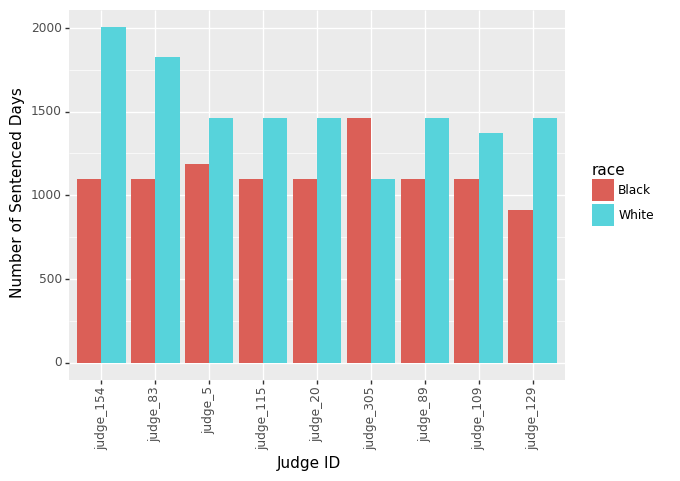

<ggplot: (8793227235675)>

In [119]:
# insert code here


#Get judges with a sufficient sample size: filter to each judge with at least 20 Black and at least 20 white defendants

black_judge_case = df_bw.groupby("judgeid_derived").agg({"is_black_derived": "sum"})
black_judge_case = black_judge_case[black_judge_case.is_black_derived >=20].reset_index()
white_judge_case = df_bw.groupby("judgeid_derived").agg({"is_white_derived": "sum"})
white_judge_case = white_judge_case[white_judge_case.is_white_derived >=20].reset_index()

sample_judge= pd.merge(black_judge_case, white_judge_case, how = "inner", on = "judgeid_derived")

#Calculate the within-judge disparity and plot the (1) median sentence length for Black defendants and (2) median sentence length for white defendants (factor variable on x axis for each judge_id who qualifies; group by race)

df_graph = df_bw[["judgeid_derived", "is_black_derived", "is_white_derived", "senlength_derived"]].copy()
df_graph["is_sample"] = [True if (sample_judge.judgeid_derived.eq(judge)).any() else False for judge in df_graph.judgeid_derived]

df_graph = df_graph[df_graph.is_sample]

df_graph= df_graph.groupby(["judgeid_derived","is_white_derived", "is_black_derived"]).agg("median").reset_index()

df_graph["race"] = np.where((df_graph.is_white_derived == True) & (df_graph.is_black_derived == False), "White", "NA")
df_graph["race"] = np.where((df_graph.is_white_derived == False) & (df_graph.is_black_derived == True), "Black", df_graph["race"])

df_graph= df_graph[['judgeid_derived', "race", "senlength_derived"]]

#Since I have 80 judges that satisfy the requirement, I decided to choose just the top 10 judges that gave the highest median sentences on the list.
#I 
select_judge = df_graph.sort_values("senlength_derived", ascending = False).judgeid_derived.unique()[0:9]

df_graph = df_graph[df_graph.judgeid_derived.isin(select_judge)] 

((plotnine.ggplot(df_graph, plotnine.aes(x='reorder(judgeid_derived, senlength_derived, ascending = False)', y='senlength_derived', fill='race')) 
  +plotnine.geom_col(stat='identity', position='dodge')
  +plotnine.theme(axis_text_x = plotnine.element_text(angle=90))
  +plotnine.xlab("Judge ID")
  +plotnine.ylab("Number of Sentenced Days")))


 #Write a 1-2 sentence interpretation - if we assume that cases/defendants are randomly assigned to sentencing judges, what might this suggest about the role of judicial discretion in these disparities?

The top ten judges with the highest median values of sentenced days tend to give White defendants more sentenced days than the Black defendants. However, Judge_305 was an exception - the median value of the Black defendant was higher in about a few hundreds day. This data suggests that the number of sentenced race may vary based on race when we assume all factors are randomized. Regardless of the race that received higher sentence, it is undeniable that there is a disparity between the two racial category. However, I believe further discussion (including analyzing whether the trend extends to other judges) is necessary to derive a conclusion. 